In [96]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from pathlib import Path
%matplotlib inline

## Data Retreival/Formatting

In [32]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [33]:
# type(alpaca_api_key)

In [34]:
crypto_client = CryptoHistoricalDataClient()

In [35]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Hour, start='2022-01-01 00:00:00'
)

btc_bars = crypto_client.get_crypto_bars(request_params)

btc_df = btc_bars.df

btc_df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2022-01-01 00:00:00+00:00  46203.0  46718.0  46201.0  46635.0   
        2022-01-01 01:00:00+00:00  46650.0  46943.0  46597.0  46794.0   
        2022-01-01 02:00:00+00:00  46816.0  46940.0  46736.0  46815.0   
        2022-01-01 03:00:00+00:00  46818.0  46888.0  46770.0  46807.0   
        2022-01-01 04:00:00+00:00  46811.0  46871.0  46640.0  46698.0   
...                                    ...      ...      ...      ...   
        2022-10-05 10:00:00+00:00  20090.0  20155.0  20086.0  20132.0   
        2022-10-05 11:00:00+00:00  20133.0  20137.0  19969.0  20036.0   
        2022-10-05 12:00:00+00:00  20035.0  20067.0  19970.0  20027.0   
        2022-10-05 13:00:00+00:00  20023.0  20041.0  19819.0  19920.0   
        2022-10-05 14:00:00+00:00  19918.0  19932.0  19742.0  19801.0   

                                     volume  trade_count          vwap  
symbol  timestamp                                                       
BTC/USD 2022-01-01 00:00:00+00:00  112.6809        410.0  46407.131966  
        2022-01-01 01:00:00+00:00   35.3480        173.0  46807.548916  
        2022-01-01 02:00:00+00:00   17.7889        235.0  46834.132543  
        2022-01-01 03:00:00+00:00   14.0900        107.0  46838.218055  
        2022-01-01 04:00:00+00:00   21.6345         89.0  46709.576232  
...                                     ...          ...           ...  
        2022-10-05 10:00:00+00:00   57.5127        307.0  20130.930288  
        2022-10-05 11:00:00+00:00   83.0275        457.0  20016.871349  
        2022-10-05 12:00:00+00:00  156.7598        541.0  20020.154547  
        2022-10-05 13:00:00+00:00  220.8769        942.0  19932.300877  
        2022-10-05 14:00:00+00:00  122.7513        563.0  19828.235653  

[6645 rows x 7 columns]

In [36]:
btc_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [37]:
btc_df = btc_df.reset_index()
btc_df = btc_df.set_index('timestamp')
btc_df = btc_df.drop(columns=['symbol'])

btc_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-01 00:00:00+00:00,46203.0,46718.0,46201.0,46635.0,112.6809,410.0,46407.131966
2022-01-01 01:00:00+00:00,46650.0,46943.0,46597.0,46794.0,35.3480,173.0,46807.548916
2022-01-01 02:00:00+00:00,46816.0,46940.0,46736.0,46815.0,17.7889,235.0,46834.132543
2022-01-01 03:00:00+00:00,46818.0,46888.0,46770.0,46807.0,14.0900,107.0,46838.218055
2022-01-01 04:00:00+00:00,46811.0,46871.0,46640.0,46698.0,21.6345,89.0,46709.576232
...,...,...,...,...,...,...,...
2022-10-05 10:00:00+00:00,20090.0,20155.0,20086.0,20132.0,57.5127,307.0,20130.930288
2022-10-05 11:00:00+00:00,20133.0,20137.0,19969.0,20036.0,83.0275,457.0,20016.871349
2022-10-05 12:00:00+00:00,20035.0,20067.0,19970.0,20027.0,156.7598,541.0,20020.154547


In [38]:
# Use the pct_change function to generate  returns from close prices
btc_df["Actual Returns"] = btc_df["close"].pct_change()

# Drop na
btc_df=btc_df.dropna()

In [39]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = btc_df[['open', 'high','low','close','volume', 'trade_count']].shift().dropna()
# Review the DataFrame
X.head()

,open,high,low,close,volume,trade_count
timestamp,,,,,,
2022-01-01 02:00:00+00:00,46650.0,46943.0,46597.0,46794.0,35.3480,173.0
2022-01-01 03:00:00+00:00,46816.0,46940.0,46736.0,46815.0,17.7889,235.0
2022-01-01 04:00:00+00:00,46818.0,46888.0,46770.0,46807.0,14.0900,107.0
2022-01-01 05:00:00+00:00,46811.0,46871.0,46640.0,46698.0,21.6345,89.0
2022-01-01 06:00:00+00:00,46693.0,47559.0,46693.0,47185.0,108.3432,343.0


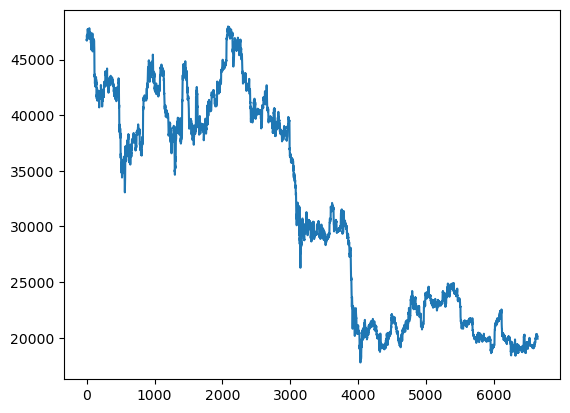

In [40]:
plt.plot(range(len(X)), X[['close']])

In [41]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 1.57643954,  1.58669664,  1.59240541,  1.5920697 , -0.42280516,
        -0.548303  ],
       [ 1.59364827,  1.58638661,  1.6068673 ,  1.59424698, -0.56241138,
        -0.4107376 ],
       [ 1.59385561,  1.58101283,  1.61040474,  1.59341754, -0.59182004,
        -0.69474359],
       ...,
       [-1.17250034, -1.1834892 , -1.17803442, -1.18220155, -0.04372225,
         0.08183529],
       [-1.18265972, -1.19072314, -1.17793038, -1.18313467,  0.5424973 ,
         0.26821422],
       [-1.18390372, -1.19341003, -1.19364078, -1.19422844,  1.05226979,
         1.15795174]])

### Data Split for Training

In [42]:
# get array representation of dataframe
dataset = btc_df.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

5316

In [43]:
# create train dataset
train_data = X_scaled[0:training_data_len, :]

# Create blank array
X_train = []
candles = 60

for i in range(candles, len(train_data)):
    X_train.append(train_data[i-candles:i, 0:6])


# create test dataset
test_data = X_scaled[training_data_len - candles: , :]

# Create blank array
X_test = []

for i in range(candles, len(test_data)):
    X_test.append(test_data[i-candles:i, 0:6])


In [44]:
# Convert lists to array

X_train = np.array(X_train)
X_test = np.array(X_test)

display(X_train.shape)
display(len(X_train))
display(len(X_test))


(5256, 60, 6)

5256

1327

In [64]:
# Create the target set selecting the Signal column and assiging it to y
y = btc_df['Actual Returns']

# Review the value counts
display(y)

# Drop first row
# y = y.iloc[1:-candles]
y=y.iloc[candles+1:]

display(y)

timestamp
2022-01-01 01:00:00+00:00    0.003409
2022-01-01 02:00:00+00:00    0.000449
2022-01-01 03:00:00+00:00   -0.000171
2022-01-01 04:00:00+00:00   -0.002329
2022-01-01 05:00:00+00:00    0.010429
                               ...   
2022-10-05 10:00:00+00:00    0.001891
2022-10-05 11:00:00+00:00   -0.004769
2022-10-05 12:00:00+00:00   -0.000449
2022-10-05 13:00:00+00:00   -0.005343
2022-10-05 14:00:00+00:00   -0.005974
Name: Actual Returns, Length: 6644, dtype: float64

timestamp
2022-01-03 14:00:00+00:00   -0.005451
2022-01-03 15:00:00+00:00   -0.004159
2022-01-03 16:00:00+00:00   -0.004648
2022-01-03 17:00:00+00:00    0.003658
2022-01-03 18:00:00+00:00   -0.004459
                               ...   
2022-10-05 10:00:00+00:00    0.001891
2022-10-05 11:00:00+00:00   -0.004769
2022-10-05 12:00:00+00:00   -0.000449
2022-10-05 13:00:00+00:00   -0.005343
2022-10-05 14:00:00+00:00   -0.005974
Name: Actual Returns, Length: 6583, dtype: float64

In [65]:
# Splitting Y data

y_train = y.iloc[0:len(X_train)]
y_test = y.iloc[len(X_train):]

display(y_train.count())
display(y_test.count())

5256

1327

## Model Creation

In [110]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


6

In [111]:
# Create the Sequential model instance
regr_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = math.ceil(((number_input_features+1)*2)/3)
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

5

64

64

In [112]:
# Add the first hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer1, return_sequences=True, input_shape=(candles,len(X.columns))))

In [113]:
# # Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [114]:
#Add the second hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer2, return_sequences=True))


In [115]:
# # Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [116]:
# #Add the third hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer2))

In [117]:
# Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [118]:
# Add Dense layer
# regr_nn.add(Dense(units=6, activation='relu'))

In [119]:
# Add the output layer to the model specifying the number of output neurons and activation function
regr_nn.add(Dense(units=1,  activation='linear'))


In [120]:
# Display the Sequential model summary, subclassed model requires build
regr_nn.build(X_train.shape)
regr_nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 60, 64)            18176     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 60, 64)            33024     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [121]:
# Compile the Sequential model

regr_nn.compile(loss='mean_squared_error', optimizer='adam')

In [122]:
# Fit the model using epochs and the training data
regr_model = regr_nn.fit(X_train, y_train, epochs=200,validation_split=0.2)

Epoch 1/200
132/132 [==============================] - 10s 77ms/step - loss: 5.4756e-04 - val_loss: 5.4454e-05
Epoch 2/200
132/132 [==============================] - 8s 60ms/step - loss: 1.1961e-04 - val_loss: 7.6108e-05
Epoch 3/200
132/132 [==============================] - 9s 66ms/step - loss: 1.0138e-04 - val_loss: 5.6981e-05
Epoch 4/200
132/132 [==============================] - 8s 63ms/step - loss: 9.0786e-05 - val_loss: 5.4607e-05
Epoch 5/200
132/132 [==============================] - 8s 62ms/step - loss: 8.0734e-05 - val_loss: 5.3882e-05
Epoch 6/200
132/132 [==============================] - 8s 58ms/step - loss: 7.9280e-05 - val_loss: 5.8153e-05
Epoch 7/200
132/132 [==============================] - 8s 58ms/step - loss: 7.8528e-05 - val_loss: 5.4498e-05
Epoch 8/200
132/132 [==============================] - 8s 58ms/step - loss: 7.7095e-05 - val_loss: 5.2831e-05
Epoch 9/200
132/132 [==============================] - 8s 59ms/step - loss: 7.5868e-05 - val_loss: 5.1470e-05
Epoch 10/

In [123]:
# Make model predictionis

y_pred=regr_nn.predict(X_test)

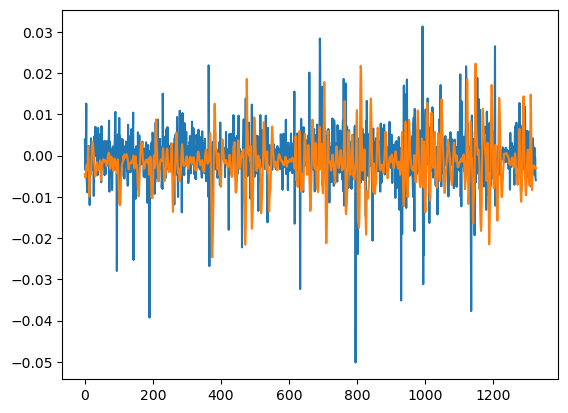

In [150]:
# Plot prediction results

plt.plot(range(len(y_test)), (y_test))
plt.plot(range(len(y_test)), (y_pred))

In [125]:
# Set the file path for the first regression model
file_path = Path('Models/regr_nn.h5')

# Export your model to a HDF5 file
regr_nn.save(file_path)